In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import xesmf
import cf_xarray
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Read in data 

# Observation count
obc_ds = xr.open_dataset('/g/data/w40/rl5183/obscount_20CRv3_rg.nc')
obc = obc_ds.obcount.sel(time='2015-12')
# HDI
hdi_ds = xr.open_dataset('/g/data/w40/rl5183/HDI_1990_2015_1x1.nc')
hdi = hdi_ds.HDI.sel(time=2015)
# Mean precip correlation
mean_corr_ds = xr.open_dataset('/g/data/w40/rl5183/20CR/precip/monthly_precip_correlations_all_members.nc')
mean_corr = mean_corr_ds.__xarray_dataarray_variable__
# Rx1 correlation
rx1_corr = xr.open_dataarray('/g/data/w40/rl5183/20CR/precip/Rx1day_correlations_all_members_1901_2015.nc')
# Mean precipitation ensemble spread
mean_std = xr.open_dataarray('/g/data/w40/rl5183/20CR/precip/prate_ensemble_std_corr_1901_2015.nc')
# Rx1 ensemble spread
rx1_std = xr.open_dataarray('/g/data/w40/rl5183/20CR/precip/Rx1day_ensemble_std_corr_1901_2015.nc')

In [3]:
# Regrid mean correlation and standrd deviation 
from_bnds = mean_corr_ds.cf.add_bounds(['latitude','longitude'])
to_bnds = hdi_ds.cf.add_bounds(['lat','lon'])
regrid = xesmf.Regridder(from_bnds, to_bnds, method='conservative_normed')
mean_corr = regrid(mean_corr)
mean_std = regrid(mean_std)

In [4]:
# Take ensemble mean and apply landmask from hdi
mean_corr = mean_corr.mean(dim='member').where(np.isfinite(hdi))
mean_std = mean_std.where(np.isfinite(hdi))
rx1_corr = rx1_corr.mean(dim='member').where(np.isfinite(hdi))
rx1_std = rx1_std.where(np.isfinite(hdi))
# Land mask for observation count data from HDI on 2x2 grid
hdi_2x2_ds = xr.open_dataset('/g/data/w40/rl5183/HDI_1990_2015_2x2.nc')
hdi_2x2 = hdi_2x2_ds.HDI.sel(time=2015)
obc=obc.where(np.isfinite(hdi_2x2))

In [5]:
# Hatching for regions with weak teleconnection 
mean_corr_ndj = mean_corr.sel(month=11)
mean_weak = mean_corr_ndj.where((mean_corr_ndj > -0.2) & (mean_corr_ndj < 0.2))
rx1_corr_ndj = rx1_corr.sel(month=11)
rx1_weak = rx1_corr_ndj.where((rx1_corr_ndj > -0.2) & (rx1_corr_ndj < 0.2))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: U

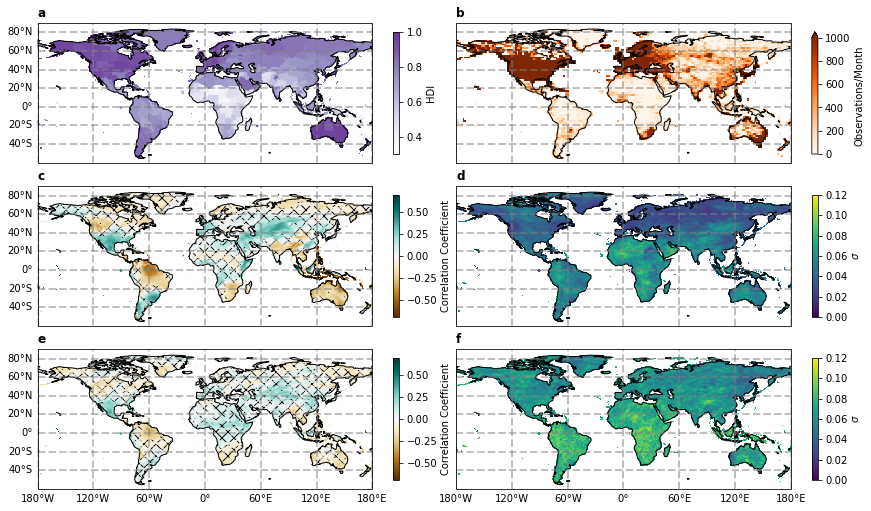

In [13]:
fig = plt.figure(figsize=(15,9))

# HDI
ax = fig.add_subplot(321, projection=ccrs.PlateCarree())
C = hdi.plot(ax=ax, vmin=0.3, add_colorbar=False, cmap='Purples', alpha=0.8, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
cbar = plt.colorbar(C, ax=ax, shrink=0.75, pad=0.05)
cbar.ax.set_ylabel('HDI', fontsize=10)
ax.set_title('a', loc='left', fontweight='bold')
ax.set_title('')

# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabels_left = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# OBSERVATION COUNT
ax = fig.add_subplot(322, projection=ccrs.PlateCarree())
C = obc.plot(ax=ax, vmin=0, vmax=1000, cmap='Oranges', alpha=1, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
cbar = plt.colorbar(C, ax=ax, extend='max', shrink=0.75, pad=0.05)
cbar.ax.set_ylabel('Observations/Month', fontsize=10)
ax.set_title('b', loc='left', fontweight='bold')
ax.set_title('')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# MEAN CORRELATION
ax = fig.add_subplot(323, projection=ccrs.PlateCarree())
C = mean_corr.sel(month=11).plot(ax=ax, vmin=-0.7, vmax=0.7, cmap='BrBG', add_colorbar=False, transform=ccrs.PlateCarree())
plt.contourf(mean_weak.lon, mean_weak.lat, mean_weak, hatches=[None, 'xx'], alpha=0)
ax.coastlines()
ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
cbar = plt.colorbar(C, ax=ax, shrink=0.75, pad=0.05)
cbar.ax.set_ylabel('Correlation Coefficient', fontsize=10)
ax.set_title('c', loc='left', fontweight='bold')
ax.set_title('')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabels_left = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# ENSEMBLE SPREAD (MEAN)
ax = fig.add_subplot(324, projection=ccrs.PlateCarree())
C = mean_std.sel(month=11).plot(ax=ax, vmin=0, vmax=0.12, cmap='viridis', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
cbar = plt.colorbar(C, ax=ax, shrink=0.75, pad=0.05)
cbar.ax.set_ylabel(''r'$\sigma$', fontsize=10)
ax.set_title('d', loc='left', fontweight='bold')
ax.set_title('')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# RX1 CORRELATION
ax = fig.add_subplot(325, projection=ccrs.PlateCarree())
C = rx1_corr.sel(month=11).plot(ax=ax, vmin=-0.7, vmax=0.7, cmap='BrBG', add_colorbar=False, transform=ccrs.PlateCarree())
plt.contourf(rx1_weak.lon, rx1_weak.lat, rx1_weak, hatches=[None, 'xx'], alpha=0)
ax.coastlines()
ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
cbar = plt.colorbar(C, ax=ax, shrink=0.75, pad=0.05)
cbar.ax.set_ylabel('Correlation Coefficient', fontsize=10)
ax.set_title('e', loc='left', fontweight='bold')
ax.set_title('')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_right = False
gl.ylabels_left = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# ENSEMBLE SPREAD RX1
ax = fig.add_subplot(326, projection=ccrs.PlateCarree())
C = rx1_std.sel(month=11).plot(ax=ax, vmin=0, vmax=0.12, cmap='viridis', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
cbar = plt.colorbar(C, ax=ax, shrink=0.75, pad=0.05)
cbar.ax.set_ylabel(''r'$\sigma$', fontsize=10)
ax.set_title('f', loc='left', fontweight='bold')
ax.set_title('')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_right = False
gl.ylabels_left = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

fig.subplots_adjust(wspace=0, hspace=0)
#plt.savefig('paper_fig_1.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)